In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%cd '/content/drive/MyDrive /phase4 public'

/content/drive/.shortcut-targets-by-id/1olR9djsPqRY8dxn01k2qeMnqfOfqWRQE/phase4 public


In [9]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.functional import F
import numpy as np
from tqdm import trange
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from utils import get_data_loaders
import tensorflow as tf
tf.test.gpu_device_name()
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

In [10]:

full_dataloaders, _ = get_data_loaders(
    {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz',
     'test': './data/12000_test_mnistmnistmsvhnsynusps.npz',
     'missing_test': './data/12000_test_mnistmnistmsvhnsynusps.npz'
     },
    batch_size= 64)

datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz', 'missing_test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600


In [6]:
use_gpu = True
device = torch.device("cuda:0" if torch.cuda.is_available() and use_gpu else "cpu")
device

device(type='cuda', index=0)

Epoch 1/10 - Train Loss: 0.9363, Train Accuracy: 69.32%, Test Accuracy: 80.95%
Epoch 2/10 - Train Loss: 0.4968, Train Accuracy: 84.75%, Test Accuracy: 85.05%
Epoch 3/10 - Train Loss: 0.3720, Train Accuracy: 88.42%, Test Accuracy: 86.38%
Epoch 4/10 - Train Loss: 0.2990, Train Accuracy: 90.64%, Test Accuracy: 86.27%
Epoch 5/10 - Train Loss: 0.2480, Train Accuracy: 92.11%, Test Accuracy: 87.22%
Epoch 6/10 - Train Loss: 0.2056, Train Accuracy: 93.48%, Test Accuracy: 87.89%
Epoch 7/10 - Train Loss: 0.1786, Train Accuracy: 94.27%, Test Accuracy: 87.61%
Epoch 8/10 - Train Loss: 0.1484, Train Accuracy: 95.31%, Test Accuracy: 87.51%
Epoch 9/10 - Train Loss: 0.1346, Train Accuracy: 95.72%, Test Accuracy: 87.76%
Epoch 10/10 - Train Loss: 0.1201, Train Accuracy: 96.13%, Test Accuracy: 86.97%


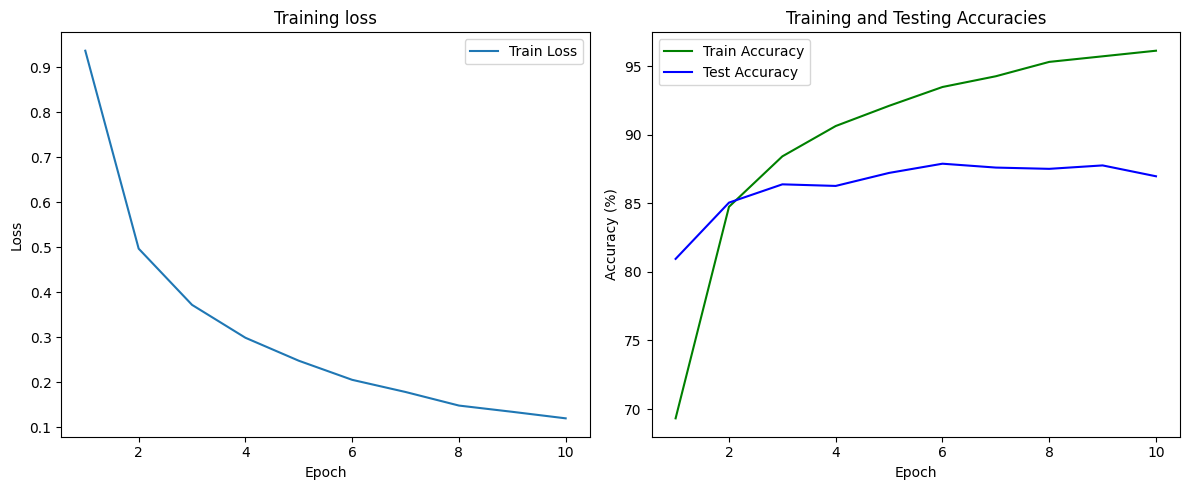

In [11]:
# Define initial model class


class DigitCNNModel(nn.Module):
    def __init__(self, num_of_features, num_classes=10):
        super(DigitCNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )

        self.fc = nn.Linear(8 * 32 * 32 + num_of_features, 128)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(128, 256)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(256, num_classes)

    def forward(self, images, features):
        cnn_out = self.conv_layers(images)
        cnn_out = cnn_out.view(cnn_out.size(0), -1) # flatten
        representation_plus_features = torch.cat((cnn_out, features), dim=1)
        fc_out = self.fc(representation_plus_features)
        fc_out = self.activation(fc_out)
        fc_out = self.fc2(fc_out)
        fc_out = self.activation(fc_out)
        output = self.output_layer(fc_out)
        return output

def train(model, train_loader, loss_function, optimizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        outputs = model(images, features)
        loss = loss_function(outputs, digit_labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()
    accuracy = 100 * correct / total
    return train_loss / len(train_loader), accuracy


def evaluate(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            outputs = model(images, features)
            loss = criterion(outputs, digit_labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


# run the model

model = DigitCNNModel(num_of_features=256).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

num_of_epochs = 10
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(num_of_epochs):
    train_loss, train_accuracy = train(model, train_loader, loss_function, optimizer)
    test_accuracy = evaluate(model, test_loader, loss_function)

    # Append the losses and accuracies to the respective lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_of_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

## plot results

plt.figure(figsize=(12, 5))

# Plotting the losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_of_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()

# Plotting the accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_of_epochs + 1), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, num_of_epochs + 1), test_accuracies, label='Test Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracies')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/10 - Train Loss: 0.5978, Train Accuracy: 81.30%, Test Accuracy: 88.84%
Epoch 2/10 - Train Loss: 0.2828, Train Accuracy: 91.42%, Test Accuracy: 91.49%
Epoch 3/10 - Train Loss: 0.1991, Train Accuracy: 93.83%, Test Accuracy: 91.38%
Epoch 4/10 - Train Loss: 0.1430, Train Accuracy: 95.57%, Test Accuracy: 91.85%
Epoch 5/10 - Train Loss: 0.1096, Train Accuracy: 96.56%, Test Accuracy: 91.84%
Epoch 6/10 - Train Loss: 0.0826, Train Accuracy: 97.40%, Test Accuracy: 92.39%
Epoch 7/10 - Train Loss: 0.0652, Train Accuracy: 97.90%, Test Accuracy: 92.32%
Epoch 8/10 - Train Loss: 0.0536, Train Accuracy: 98.34%, Test Accuracy: 92.29%
Epoch 9/10 - Train Loss: 0.0454, Train Accuracy: 98.58%, Test Accuracy: 92.03%
Epoch 10/10 - Train Loss: 0.0402, Train Accuracy: 98.75%, Test Accuracy: 92.06%


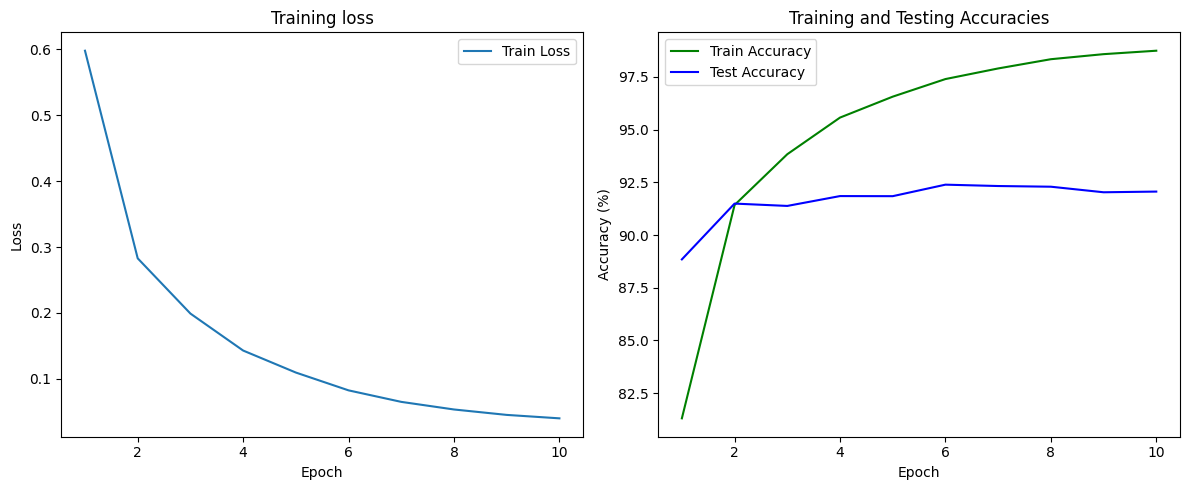

In [9]:
# Define initial model class


class DigitCNNModel(nn.Module):
    def __init__(self, num_of_features, num_classes=10):
        super(DigitCNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Linear(64 * 8 * 8 + num_of_features, 128)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(128, num_classes)

    def forward(self, images, features):
        cnn_out = self.conv_layers(images)
        cnn_out = cnn_out.view(cnn_out.size(0), -1) # flatten
        representation_plus_features = torch.cat((cnn_out, features), dim=1)
        fc_out = self.fc(representation_plus_features)
        fc_out = self.activation(fc_out)
        output = self.output_layer(fc_out)
        return output

def train(model, train_loader, loss_function, optimizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        outputs = model(images, features)
        loss = loss_function(outputs, digit_labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()
    accuracy = 100 * correct / total
    return train_loss / len(train_loader), accuracy


def evaluate(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            outputs = model(images, features)
            loss = criterion(outputs, digit_labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


# run the model

model = DigitCNNModel(num_of_features=256).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

num_of_epochs = 10
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(num_of_epochs):
    train_loss, train_accuracy = train(model, train_loader, loss_function, optimizer)
    test_accuracy = evaluate(model, test_loader, loss_function)

    # Append the losses and accuracies to the respective lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_of_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

## plot results

plt.figure(figsize=(12, 5))

# Plotting the losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_of_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()

# Plotting the accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_of_epochs + 1), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, num_of_epochs + 1), test_accuracies, label='Test Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracies')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/10 - Train Loss: 0.5998, Train Accuracy: 81.01%, Test Accuracy: 89.60%
Epoch 2/10 - Train Loss: 0.2698, Train Accuracy: 91.59%, Test Accuracy: 91.27%
Epoch 3/10 - Train Loss: 0.1869, Train Accuracy: 94.16%, Test Accuracy: 92.26%
Epoch 4/10 - Train Loss: 0.1414, Train Accuracy: 95.57%, Test Accuracy: 92.71%
Epoch 5/10 - Train Loss: 0.1050, Train Accuracy: 96.68%, Test Accuracy: 92.90%
Epoch 6/10 - Train Loss: 0.0839, Train Accuracy: 97.38%, Test Accuracy: 93.06%
Epoch 7/10 - Train Loss: 0.0688, Train Accuracy: 97.89%, Test Accuracy: 92.62%
Epoch 8/10 - Train Loss: 0.0512, Train Accuracy: 98.45%, Test Accuracy: 92.73%
Epoch 9/10 - Train Loss: 0.0437, Train Accuracy: 98.60%, Test Accuracy: 92.92%
Epoch 10/10 - Train Loss: 0.0419, Train Accuracy: 98.69%, Test Accuracy: 93.32%


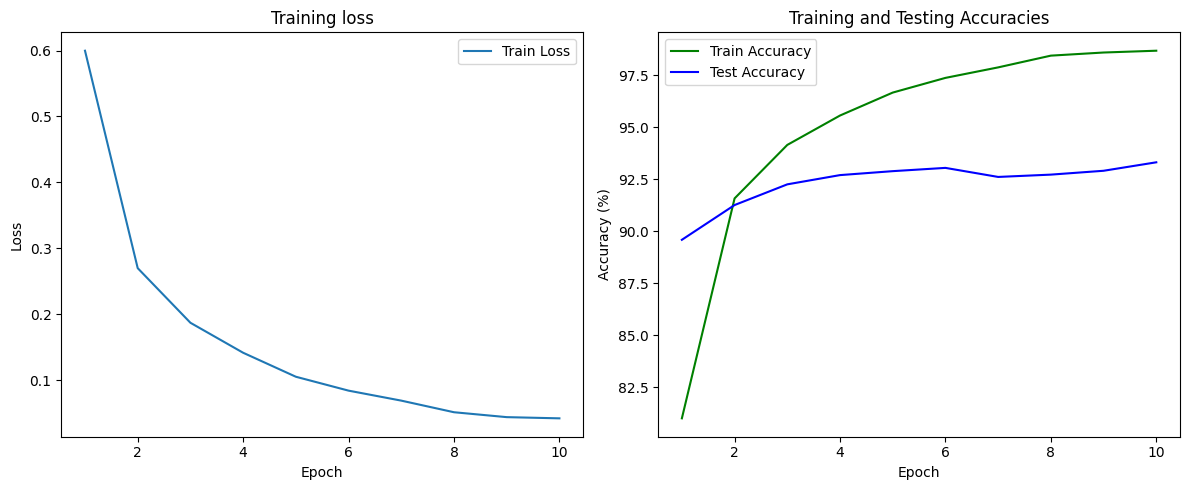

In [36]:
# Define initial model class


class DigitCNNModel(nn.Module):
    def __init__(self, num_of_features, num_classes=10):
        super(DigitCNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Linear(64 * 4 * 4 + num_of_features, 256)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(256, num_classes)

    def forward(self, images, features):
        cnn_out = self.conv_layers(images)
        cnn_out = cnn_out.view(cnn_out.size(0), -1) # flatten
        representation_plus_features = torch.cat((cnn_out, features), dim=1)
        fc_out = self.fc(representation_plus_features)
        fc_out = self.activation(fc_out)
        output = self.output_layer(fc_out)
        return output

def train(model, train_loader, loss_function, optimizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        outputs = model(images, features)
        loss = loss_function(outputs, digit_labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()
    accuracy = 100 * correct / total
    return train_loss / len(train_loader), accuracy


def evaluate(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            outputs = model(images, features)
            loss = criterion(outputs, digit_labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


# run the model

model = DigitCNNModel(num_of_features=256).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

num_of_epochs = 10
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(num_of_epochs):
    train_loss, train_accuracy = train(model, train_loader, loss_function, optimizer)
    test_accuracy = evaluate(model, test_loader, loss_function)

    # Append the losses and accuracies to the respective lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_of_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

## plot results

plt.figure(figsize=(12, 5))

# Plotting the losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_of_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()

# Plotting the accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_of_epochs + 1), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, num_of_epochs + 1), test_accuracies, label='Test Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracies')
plt.legend()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
<ipython-input-38-b544360bde51>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  fc_out = self.activation(fc_out)


Epoch 1/10 - Train Loss: 1.9621, Train Accuracy: 39.15%, Test Accuracy: 50.27%
Epoch 2/10 - Train Loss: 1.4357, Train Accuracy: 55.22%, Test Accuracy: 56.97%
Epoch 3/10 - Train Loss: 1.1899, Train Accuracy: 59.41%, Test Accuracy: 60.87%
Epoch 4/10 - Train Loss: 1.0581, Train Accuracy: 63.90%, Test Accuracy: 63.44%
Epoch 5/10 - Train Loss: 0.9665, Train Accuracy: 67.17%, Test Accuracy: 67.20%
Epoch 6/10 - Train Loss: 0.8855, Train Accuracy: 70.69%, Test Accuracy: 71.80%
Epoch 7/10 - Train Loss: 0.8093, Train Accuracy: 73.74%, Test Accuracy: 73.54%
Epoch 8/10 - Train Loss: 0.7513, Train Accuracy: 75.45%, Test Accuracy: 74.40%
Epoch 9/10 - Train Loss: 0.7026, Train Accuracy: 76.98%, Test Accuracy: 75.49%
Epoch 10/10 - Train Loss: 0.6577, Train Accuracy: 78.61%, Test Accuracy: 77.62%


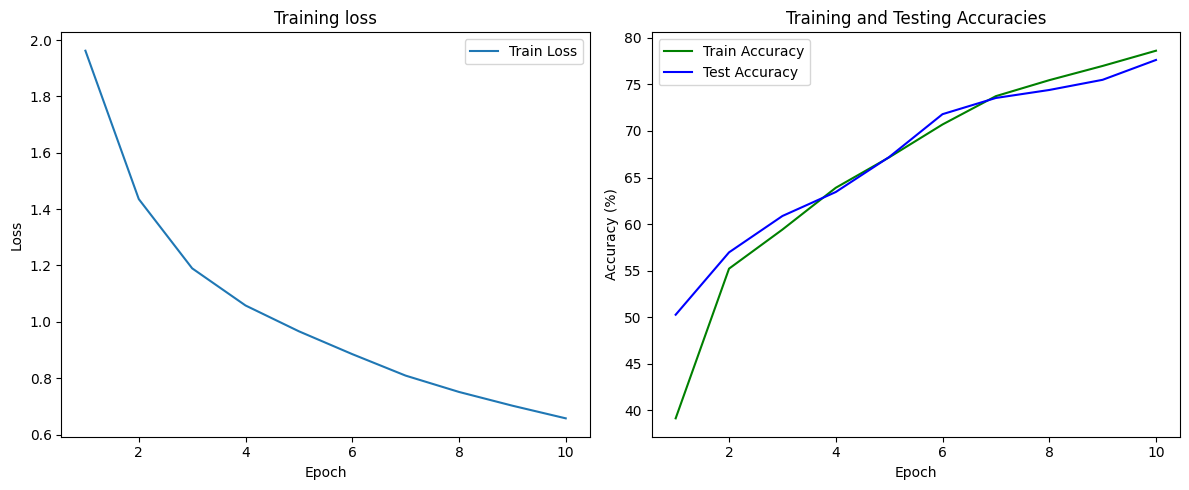

In [38]:
# testing others activation functions : soft_max()


class DigitCNNModel(nn.Module):
    def __init__(self, num_of_features, num_classes=10):
        super(DigitCNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.Softmax(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.Softmax(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.Softmax(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Linear(64 * 4 * 4 + num_of_features, 256)
        self.activation = nn.Softmax()
        self.output_layer = nn.Linear(256, num_classes)

    def forward(self, images, features):
        cnn_out = self.conv_layers(images)
        cnn_out = cnn_out.view(cnn_out.size(0), -1) # flatten
        representation_plus_features = torch.cat((cnn_out, features), dim=1)
        fc_out = self.fc(representation_plus_features)
        fc_out = self.activation(fc_out)
        output = self.output_layer(fc_out)
        return output

def train(model, train_loader, loss_function, optimizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        outputs = model(images, features)
        loss = loss_function(outputs, digit_labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()
    accuracy = 100 * correct / total
    return train_loss / len(train_loader), accuracy


def evaluate(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            outputs = model(images, features)
            loss = criterion(outputs, digit_labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


# run the model

model = DigitCNNModel(num_of_features=256).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

num_of_epochs = 10
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(num_of_epochs):
    train_loss, train_accuracy = train(model, train_loader, loss_function, optimizer)
    test_accuracy = evaluate(model, test_loader, loss_function)

    # Append the losses and accuracies to the respective lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_of_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

## plot results

plt.figure(figsize=(12, 5))

# Plotting the losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_of_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()

# Plotting the accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_of_epochs + 1), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, num_of_epochs + 1), test_accuracies, label='Test Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracies')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/10 - Train Loss: 0.5695, Train Accuracy: 81.85%, Test Accuracy: 89.09%
Epoch 2/10 - Train Loss: 0.2692, Train Accuracy: 91.59%, Test Accuracy: 91.30%
Epoch 3/10 - Train Loss: 0.1938, Train Accuracy: 93.99%, Test Accuracy: 91.53%
Epoch 4/10 - Train Loss: 0.1393, Train Accuracy: 95.72%, Test Accuracy: 91.96%
Epoch 5/10 - Train Loss: 0.0988, Train Accuracy: 97.11%, Test Accuracy: 92.04%
Epoch 6/10 - Train Loss: 0.0669, Train Accuracy: 98.17%, Test Accuracy: 92.15%
Epoch 7/10 - Train Loss: 0.0498, Train Accuracy: 98.64%, Test Accuracy: 92.06%
Epoch 8/10 - Train Loss: 0.0356, Train Accuracy: 99.08%, Test Accuracy: 91.45%
Epoch 9/10 - Train Loss: 0.0281, Train Accuracy: 99.30%, Test Accuracy: 91.66%
Epoch 10/10 - Train Loss: 0.0274, Train Accuracy: 99.23%, Test Accuracy: 91.80%


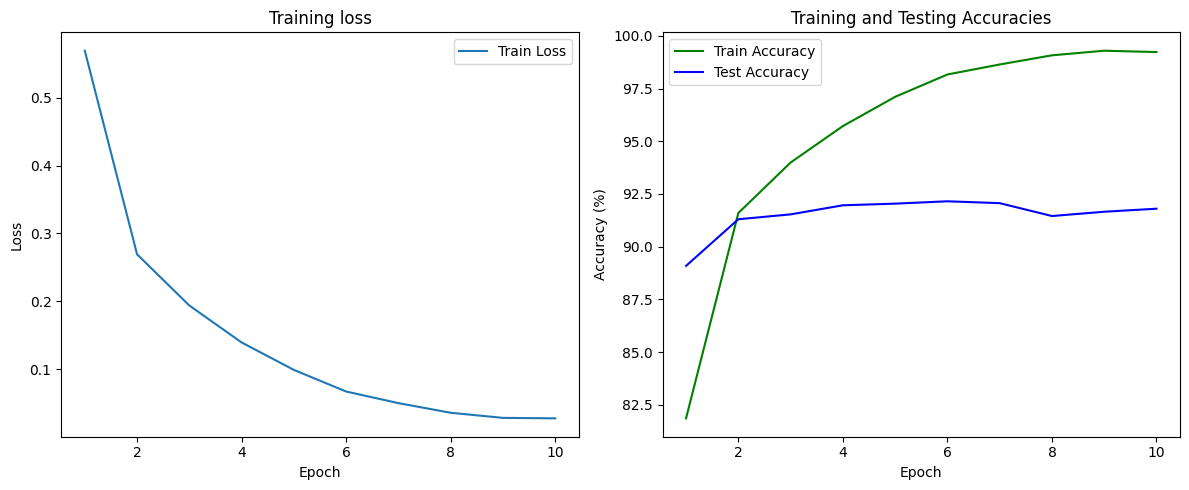

In [39]:
# testing others activation functions : tanh()


class DigitCNNModel(nn.Module):
    def __init__(self, num_of_features, num_classes=10):
        super(DigitCNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Linear(64 * 4 * 4 + num_of_features, 256)
        self.activation = nn.Tanh()
        self.output_layer = nn.Linear(256, num_classes)

    def forward(self, images, features):
        cnn_out = self.conv_layers(images)
        cnn_out = cnn_out.view(cnn_out.size(0), -1) # flatten
        representation_plus_features = torch.cat((cnn_out, features), dim=1)
        fc_out = self.fc(representation_plus_features)
        fc_out = self.activation(fc_out)
        output = self.output_layer(fc_out)
        return output

def train(model, train_loader, loss_function, optimizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        outputs = model(images, features)
        loss = loss_function(outputs, digit_labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()
    accuracy = 100 * correct / total
    return train_loss / len(train_loader), accuracy


def evaluate(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            outputs = model(images, features)
            loss = criterion(outputs, digit_labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


# run the model

model = DigitCNNModel(num_of_features=256).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

num_of_epochs = 10
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(num_of_epochs):
    train_loss, train_accuracy = train(model, train_loader, loss_function, optimizer)
    test_accuracy = evaluate(model, test_loader, loss_function)

    # Append the losses and accuracies to the respective lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_of_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

## plot results

plt.figure(figsize=(12, 5))

# Plotting the losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_of_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()

# Plotting the accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_of_epochs + 1), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, num_of_epochs + 1), test_accuracies, label='Test Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracies')
plt.legend()

plt.tight_layout()
plt.show()


datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
reading ./data/12000_test_mnistmnistmsvhnsynusps.npz, number of samples: 21600
datafiles to read:  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz', 'test': './data/12000_test_mnistmnistmsvhnsynusps.npz'}
reading ./data/12000_train_mnistmnistmsvhnsynusps.npz, number of samples: 60000
reading ./data/12000_test_mnistmnistmsv

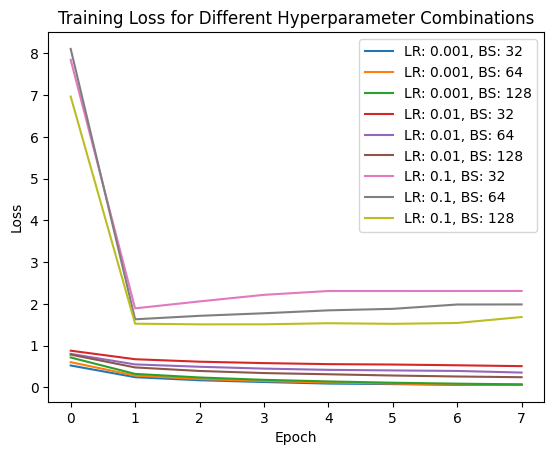


Best Test Accuracy: 0.9318
Best Learning Rate: 0.001, Best Batch Size: 32


In [10]:
# tune_learning_Rate and batch_size

class DigitCNNModel(nn.Module):
    def __init__(self, num_of_features, num_classes=10):
        super(DigitCNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Linear(64 * 4 * 4 + num_of_features, 256)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(256, num_classes)

    def forward(self, images, features):
        cnn_out = self.conv_layers(images)
        cnn_out = cnn_out.view(cnn_out.size(0), -1) # flatten
        representation_plus_features = torch.cat((cnn_out, features), dim=1)
        fc_out = self.fc(representation_plus_features)
        fc_out = self.activation(fc_out)
        output = self.output_layer(fc_out)
        return output


# Function to train the model
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        optimizer.zero_grad()
        output = model(images, features)
        loss = criterion(output, digit_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

    accuracy = correct / total
    return running_loss / len(train_loader), accuracy

# Function to evaluate the model
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            output = model(images, features)
            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()
    accuracy = correct / total
    return accuracy


# Function to perform hyperparameter tuning
def hyperparameter_tuning(learning_rates, batch_sizes, num_epochs):
    # Initialize dictionary to store hyperparameter results
    results = {}

    # Hyperparameter tuning loop
    for lr in learning_rates:
        for bs in batch_sizes:
            # Create a new instance of the model with the specified hyperparameters
            model = DigitCNNModel(num_of_features=256).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)



            full_dataloaders, _ = get_data_loaders(
                  {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz',
                  'test': './data/12000_test_mnistmnistmsvhnsynusps.npz',
                  },
                  batch_size= bs)

            # Training loop
            train_losses = []
            for epoch in range(num_epochs):
                train_loss, train_accuracy = train(model, full_dataloaders['train'], criterion, optimizer, device)
                test_accuracy = evaluate(model, full_dataloaders['test'], device)
                train_losses.append(train_loss)

            # Store the test accuracy and training losses for the hyperparameter combination
            results[(lr, bs)] = {'test_accuracy': test_accuracy, 'train_losses': train_losses}

    return results

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameter tuning settings
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [32, 64, 128]
num_epochs = 8

# Perform hyperparameter tuning
tuning_results = hyperparameter_tuning(learning_rates, batch_sizes, num_epochs)

# Print and plot the results
for lr, bs in tuning_results:
    test_accuracy = tuning_results[(lr, bs)]['test_accuracy']
    train_losses = tuning_results[(lr, bs)]['train_losses']
    print(f"Learning Rate: {lr}, Batch Size: {bs}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    plt.plot(train_losses, label=f"LR: {lr}, BS: {bs}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for Different Hyperparameter Combinations")
plt.legend()
plt.show()

# Find the best test accuracy and its corresponding hyperparameters
best_lr, best_bs = max(tuning_results, key=lambda x: tuning_results[x]['test_accuracy'])
best_test_accuracy = tuning_results[(best_lr, best_bs)]['test_accuracy']
print(f"\nBest Test Accuracy: {best_test_accuracy:.4f}")
print(f"Best Learning Rate: {best_lr}, Best Batch Size: {best_bs}")

In [ ]:
# set_tuned batch size
full_dataloaders, _ = get_data_loaders(
    {'train': './data/12000_train_mnistmnistmsvhnsynusps.npz',
     'test': './data/12000_test_mnistmnistmsvhnsynusps.npz',
     'missing_test': './data/12000_test_mnistmnistmsvhnsynusps.npz'
     },
    batch_size= 32)

Epoch 1/25 - Train Loss: 0.6037, Train Accuracy: 81.01%, Test Accuracy: 89.81%
Epoch 2/25 - Train Loss: 0.2704, Train Accuracy: 91.70%, Test Accuracy: 91.83%
Epoch 3/25 - Train Loss: 0.1928, Train Accuracy: 94.01%, Test Accuracy: 92.24%
Epoch 4/25 - Train Loss: 0.1432, Train Accuracy: 95.58%, Test Accuracy: 92.01%
Epoch 5/25 - Train Loss: 0.1085, Train Accuracy: 96.70%, Test Accuracy: 92.84%
Epoch 6/25 - Train Loss: 0.0847, Train Accuracy: 97.34%, Test Accuracy: 93.18%
Epoch 7/25 - Train Loss: 0.0704, Train Accuracy: 97.78%, Test Accuracy: 92.96%
Epoch 8/25 - Train Loss: 0.0553, Train Accuracy: 98.26%, Test Accuracy: 92.91%
Epoch 9/25 - Train Loss: 0.0469, Train Accuracy: 98.52%, Test Accuracy: 92.72%
Epoch 10/25 - Train Loss: 0.0404, Train Accuracy: 98.81%, Test Accuracy: 92.80%
Epoch 11/25 - Train Loss: 0.0354, Train Accuracy: 98.92%, Test Accuracy: 93.13%
Epoch 12/25 - Train Loss: 0.0318, Train Accuracy: 99.00%, Test Accuracy: 92.95%
Epoch 13/25 - Train Loss: 0.0285, Train Accuracy:

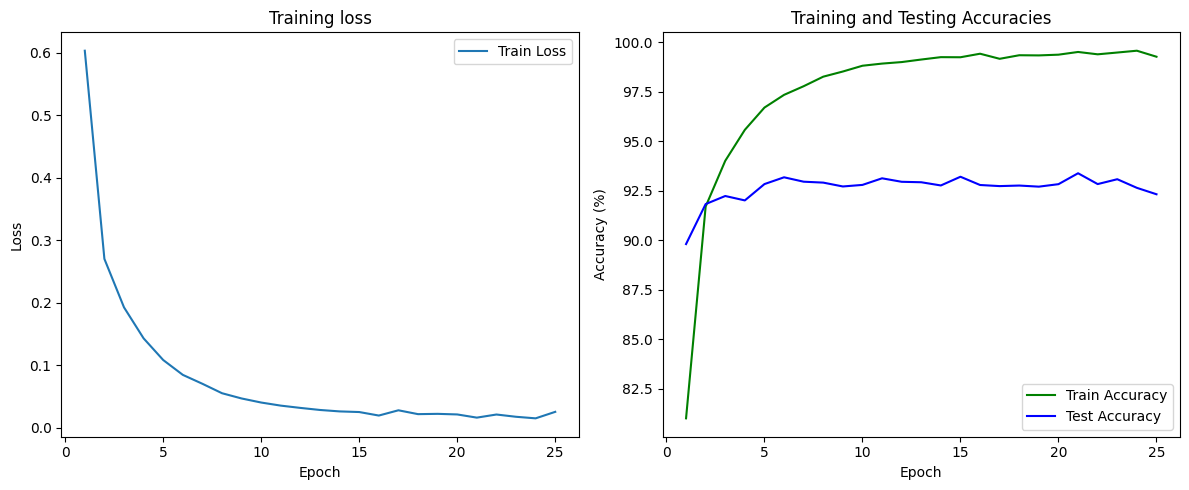

In [15]:
# tune epoch number


class DigitCNNModel(nn.Module):
    def __init__(self, num_of_features, num_classes=10):
        super(DigitCNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Linear(64 * 4 * 4 + num_of_features, 256)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(256, num_classes)

    def forward(self, images, features):
        cnn_out = self.conv_layers(images)
        cnn_out = cnn_out.view(cnn_out.size(0), -1) # flatten
        representation_plus_features = torch.cat((cnn_out, features), dim=1)
        fc_out = self.fc(representation_plus_features)
        fc_out = self.activation(fc_out)
        output = self.output_layer(fc_out)
        return output

def train(model, train_loader, loss_function, optimizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        outputs = model(images, features)
        loss = loss_function(outputs, digit_labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()
    accuracy = 100 * correct / total
    return train_loss / len(train_loader), accuracy


def evaluate(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            outputs = model(images, features)
            loss = criterion(outputs, digit_labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


# run the model

model = DigitCNNModel(num_of_features=256).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

num_of_epochs = 25
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(num_of_epochs):
    train_loss, train_accuracy = train(model, train_loader, loss_function, optimizer)
    test_accuracy = evaluate(model, test_loader, loss_function)

    # Append the losses and accuracies to the respective lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_of_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

## plot results

plt.figure(figsize=(12, 5))

# Plotting the losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_of_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()

# Plotting the accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_of_epochs + 1), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, num_of_epochs + 1), test_accuracies, label='Test Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracies')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/15 - Loss: 0.7794 - Train Accuracy: 0.7604 - Test Accuracy: 0.8834
Epoch 2/15 - Loss: 0.4223 - Train Accuracy: 0.8817 - Test Accuracy: 0.9133
Epoch 3/15 - Loss: 0.3476 - Train Accuracy: 0.9055 - Test Accuracy: 0.9209
Epoch 4/15 - Loss: 0.3026 - Train Accuracy: 0.9211 - Test Accuracy: 0.9265
Epoch 5/15 - Loss: 0.2752 - Train Accuracy: 0.9320 - Test Accuracy: 0.9305
Epoch 6/15 - Loss: 0.2555 - Train Accuracy: 0.9389 - Test Accuracy: 0.9308
Epoch 7/15 - Loss: 0.2387 - Train Accuracy: 0.9450 - Test Accuracy: 0.9288
Epoch 8/15 - Loss: 0.2264 - Train Accuracy: 0.9494 - Test Accuracy: 0.9315
Epoch 9/15 - Loss: 0.2206 - Train Accuracy: 0.9536 - Test Accuracy: 0.9345
Epoch 10/15 - Loss: 0.2071 - Train Accuracy: 0.9582 - Test Accuracy: 0.9344
Epoch 11/15 - Loss: 0.2048 - Train Accuracy: 0.9600 - Test Accuracy: 0.9383
Epoch 12/15 - Loss: 0.1994 - Train Accuracy: 0.9626 - Test Accuracy: 0.9386
Epoch 13/15 - Loss: 0.1957 - Train Accuracy: 0.9639 - Test Accuracy: 0.9387
Epoch 14/15 - Loss: 0

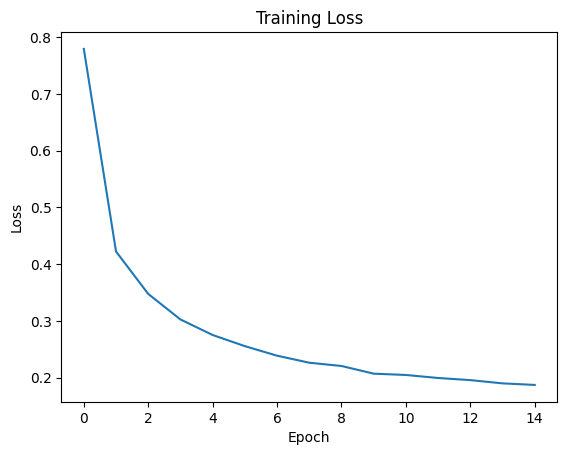

In [16]:
# Adding regularization and drop out, l2=0.001

class DigitCNNModel(nn.Module):
    def __init__(self, num_of_features, num_classes=10, dropout_rate = 0.5):
        super(DigitCNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Linear(64 * 4 * 4 + num_of_features, 256)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)  # Add dropout layer
        self.output_layer = nn.Linear(256, num_classes)

    def forward(self, images, features):
        cnn_out = self.conv_layers(images)
        cnn_out = cnn_out.view(cnn_out.size(0), -1) # flatten
        representation_plus_features = torch.cat((cnn_out, features), dim=1)
        fc_out = self.fc(representation_plus_features)
        fc_out = self.activation(fc_out)
        fc_output = self.dropout(fc_out)  # Apply dropout
        output = self.output_layer(fc_output)
        return output
# Function to train the model
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        optimizer.zero_grad()
        output = model(images, features)
        loss = criterion(output, digit_labels)

        # L2 Regularization (Weight Decay)
        l2_lambda = 0.001  # Adjust this regularization parameter
        l2_reg = torch.tensor(0.).to(device)
        for param in model.parameters():
            l2_reg += torch.norm(param)
        loss += l2_lambda * l2_reg

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

    accuracy = correct / total
    return running_loss / len(train_loader), accuracy


# Function to evaluate the model
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            output = model(images, features)
            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()
    accuracy = correct / total
    return accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DigitCNNModel(num_of_features=256, dropout_rate=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

# Training loop
num_epochs = 15
train_losses = []
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_accuracy = evaluate(model, test_loader, device)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")

# Plotting the train loss#
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()



Epoch 1/15 - Loss: 1.0162 - Train Accuracy: 0.7612 - Test Accuracy: 0.8859
Epoch 2/15 - Loss: 0.7187 - Train Accuracy: 0.8766 - Test Accuracy: 0.9097
Epoch 3/15 - Loss: 0.6739 - Train Accuracy: 0.8974 - Test Accuracy: 0.9180
Epoch 4/15 - Loss: 0.6590 - Train Accuracy: 0.9061 - Test Accuracy: 0.9165
Epoch 5/15 - Loss: 0.6405 - Train Accuracy: 0.9167 - Test Accuracy: 0.9233
Epoch 6/15 - Loss: 0.6312 - Train Accuracy: 0.9227 - Test Accuracy: 0.9300
Epoch 7/15 - Loss: 0.6291 - Train Accuracy: 0.9237 - Test Accuracy: 0.9308
Epoch 8/15 - Loss: 0.6206 - Train Accuracy: 0.9290 - Test Accuracy: 0.9294
Epoch 9/15 - Loss: 0.6169 - Train Accuracy: 0.9318 - Test Accuracy: 0.9350
Epoch 10/15 - Loss: 0.6141 - Train Accuracy: 0.9324 - Test Accuracy: 0.9306
Epoch 11/15 - Loss: 0.6120 - Train Accuracy: 0.9351 - Test Accuracy: 0.9364
Epoch 12/15 - Loss: 0.6098 - Train Accuracy: 0.9361 - Test Accuracy: 0.9349
Epoch 13/15 - Loss: 0.6075 - Train Accuracy: 0.9379 - Test Accuracy: 0.9300
Epoch 14/15 - Loss: 0

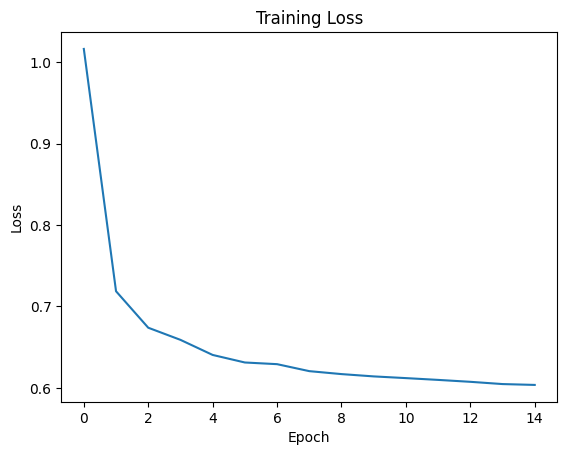

In [17]:
# Adding regularization and drop out , l2 = 0.01

class DigitCNNModel(nn.Module):
    def __init__(self, num_of_features, num_classes=10, dropout_rate = 0.5):
        super(DigitCNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Linear(64 * 4 * 4 + num_of_features, 256)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)  # Add dropout layer
        self.output_layer = nn.Linear(256, num_classes)

    def forward(self, images, features):
        cnn_out = self.conv_layers(images)
        cnn_out = cnn_out.view(cnn_out.size(0), -1) # flatten
        representation_plus_features = torch.cat((cnn_out, features), dim=1)
        fc_out = self.fc(representation_plus_features)
        fc_out = self.activation(fc_out)
        fc_output = self.dropout(fc_out)  # Apply dropout
        output = self.output_layer(fc_output)
        return output
# Function to train the model
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, features, _, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)

        optimizer.zero_grad()
        output = model(images, features)
        loss = criterion(output, digit_labels)

        # L2 Regularization (Weight Decay)
        l2_lambda = 0.01  # Adjust this regularization parameter
        l2_reg = torch.tensor(0.).to(device)
        for param in model.parameters():
            l2_reg += torch.norm(param)
        loss += l2_lambda * l2_reg

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

    accuracy = correct / total
    return running_loss / len(train_loader), accuracy


# Function to evaluate the model
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, features, _, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)

            output = model(images, features)
            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()
    accuracy = correct / total
    return accuracy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DigitCNNModel(num_of_features=256, dropout_rate=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']

# Training loop
num_epochs = 15
train_losses = []
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_accuracy = evaluate(model, test_loader, device)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")

# Plotting the train loss#
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()



In [12]:
# triplet_loss

class TripletLoss(nn.Module):
    def __init__(self, margin: float = 0.05):
        device = torch.device("cuda:0" if torch.cuda.is_available() and use_gpu else "cpu")
        super().__init__()
        self.margin = torch.tensor(margin)
        self.device = device

    def forward(self, embeddings, labels):
        dp, dn = self.batch_hard_triplet_loss(embeddings, labels)

        triplet_loss = torch.mean(torch.clamp(dp - dn + self.margin, min=0))
        return triplet_loss

    def batch_hard_triplet_loss(self, embeddings, labels):
        dists = self.euclidean_dist(embeddings, embeddings)

        same_identity_mask = torch.eq(labels[:, None], labels[None, :])
        negative_mask = torch.logical_not(same_identity_mask)
        positive_mask = torch.logical_xor(same_identity_mask, torch.eye(labels.shape[0], dtype=torch.bool).to(self.device))

        dp, _ = torch.max(dists * positive_mask.int(), dim=1)

        dn = torch.zeros_like(dp)
        for i in range(dists.shape[0]):
            dn[i] = torch.min(dists[i, :][negative_mask[i, :]])

        return dp, dn

    def all_diffs(self, a, b):
        return a[:, None] - b[None, :]

    def euclidean_dist(self, embed1, embed2):
        diffs = self.all_diffs(embed1, embed2)
        t1 = torch.square(diffs)
        t2 = torch.sum(t1, dim=-1)
        return torch.sqrt(t2 + 1e-12)

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DigitCNNModel(nn.Module):
    def __init__(self, num_of_features, num_classes=10):
        super(DigitCNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Linear(64 * 4 * 4 + num_of_features, 256)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.output_layer = nn.Linear(256, num_classes)

    def forward(self, images, features):
        images = images.to(device)  # Move images to GPU
        images = images.to(self.conv_layers[0].weight.device)

        cnn_out = self.conv_layers(images)
        cnn_out = cnn_out.view(cnn_out.size(0), -1) # flatten
        representation_plus_features = torch.cat((cnn_out, features), dim=1)
        layer_before_output_layer_features = F.relu((self.fc(representation_plus_features)))
        dropout_output = self.dropout(layer_before_output_layer_features)
        output = self.output_layer(dropout_output)
        return layer_before_output_layer_features, output

# Define the training function
def train(model, train_loader, criterion, triplet_loss, optimizer, landa):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    for batch_idx, (images, features, domain_labels, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)
        domain_labels = domain_labels.to(device)
        optimizer.zero_grad()
        f, output = model(images, features)
        loss_ce = criterion(output, digit_labels)
        loss_triplet = triplet_loss(f, domain_labels)
        loss = loss_ce + landa * loss_triplet
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

        triplet_loss_sum += loss_triplet.item()
        cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(train_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(train_loader)
    total_loss = running_loss / len(train_loader)
    return total_loss, accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss

# Define the evaluation function
def evaluate(model, test_loader, criterion, triplet_loss):
    model.eval()
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    with torch.no_grad():
        for images, features, domain_labels, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)
            domain_labels = domain_labels.to(device)
            f, output = model(images, features)
            loss_ce = criterion(output, digit_labels)
            loss_triplet = triplet_loss(f, domain_labels)

            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

            triplet_loss_sum += loss_triplet.item()
            cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(test_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(test_loader)
    total_loss = (avg_triplet_loss + avg_cross_entropy_loss)
    return accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss, total_loss
# Example usage
model = DigitCNNModel(num_of_features=256)
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
triplet_loss = TripletLoss(margin=0.01).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Access the train and test loaders using the keys 'train' and 'test'
train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']


# Training loop
num_epochs = 15
landa = 0.1  # Hyperparameter to control the impact of the Triplet Loss

train_losses = []
test_losses = []
train_triplet_losses = []
test_triplet_losses = []
train_cross_entropy_losses = []
test_cross_entropy_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy, train_triplet_loss, train_cross_entropy_loss = train(model, train_loader, criterion, triplet_loss, optimizer, landa)
    test_accuracy, test_triplet_loss, test_cross_entropy_loss, test_total_loss = evaluate(model, test_loader, criterion, triplet_loss)

    train_losses.append(train_loss)
    test_losses.append(test_total_loss)
    train_triplet_losses.append(train_triplet_loss)
    test_triplet_losses.append(test_triplet_loss)
    train_cross_entropy_losses.append(train_cross_entropy_loss)
    test_cross_entropy_losses.append(test_cross_entropy_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} - Test Loss: {test_total_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")
    print(f"Train Triplet Loss: {train_triplet_loss:.4f} - Test Triplet Loss: {test_triplet_loss:.4f}")
    print(f"Train Cross Entropy Loss: {train_cross_entropy_loss:.4f} - Test Cross Entropy Loss: {test_cross_entropy_loss:.4f}")
    print(f"Train Total Loss: {train_loss:.4f} - Test Total Loss: {test_total_loss:.4f}")
    print()




Epoch 1/15
Train Loss: 0.9909 - Test Loss: 2.2574
Train Accuracy: 0.7588 - Test Accuracy: 0.8988
Train Triplet Loss: 2.0227 - Test Triplet Loss: 1.9172
Train Cross Entropy Loss: 0.7886 - Test Cross Entropy Loss: 0.3402
Train Total Loss: 0.9909 - Test Total Loss: 2.2574

Epoch 2/15
Train Loss: 0.4541 - Test Loss: 1.3895
Train Accuracy: 0.8926 - Test Accuracy: 0.9161
Train Triplet Loss: 1.0251 - Test Triplet Loss: 1.1215
Train Cross Entropy Loss: 0.3516 - Test Cross Entropy Loss: 0.2680
Train Total Loss: 0.4541 - Test Total Loss: 1.3895

Epoch 3/15
Train Loss: 0.3358 - Test Loss: 1.2981
Train Accuracy: 0.9162 - Test Accuracy: 0.9285
Train Triplet Loss: 0.6460 - Test Triplet Loss: 1.0577
Train Cross Entropy Loss: 0.2712 - Test Cross Entropy Loss: 0.2405
Train Total Loss: 0.3358 - Test Total Loss: 1.2981

Epoch 4/15
Train Loss: 0.2753 - Test Loss: 1.1985
Train Accuracy: 0.9287 - Test Accuracy: 0.9305
Train Triplet Loss: 0.4785 - Test Triplet Loss: 0.9725
Train Cross Entropy Loss: 0.2274 - 

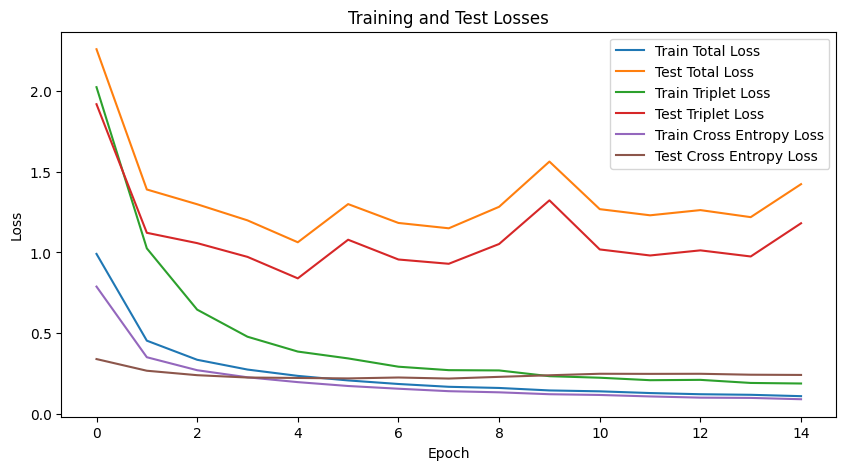

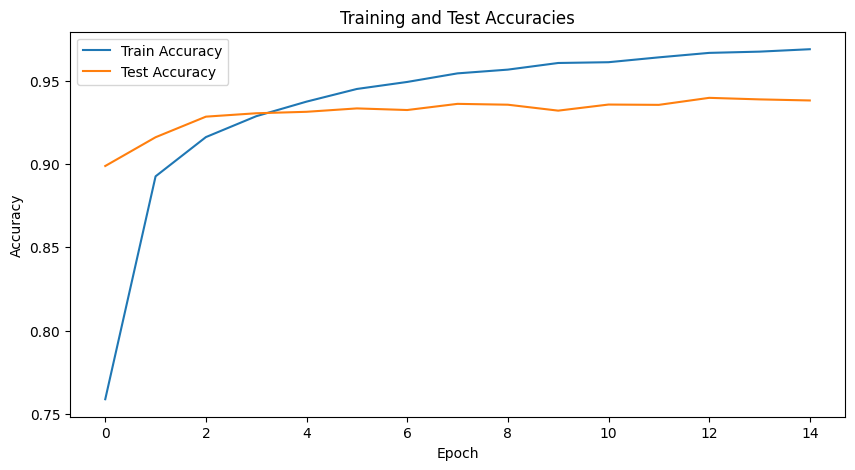

In [47]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Total Loss')
plt.plot(test_losses, label='Test Total Loss')
plt.plot(train_triplet_losses, label='Train Triplet Loss')
plt.plot(test_triplet_losses, label='Test Triplet Loss')
plt.plot(train_cross_entropy_losses, label='Train Cross Entropy Loss')
plt.plot(test_cross_entropy_losses, label='Test Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Losses')
plt.show()

# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Test Accuracies')
plt.show()

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DigitCNNModel(nn.Module):
    def __init__(self, num_of_features, num_classes=10):
        super(DigitCNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Linear(64 * 4 * 4 + num_of_features, 256)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.output_layer = nn.Linear(256, num_classes)

    def forward(self, images, features):
        images = images.to(device)  # Move images to GPU
        images = images.to(self.conv_layers[0].weight.device)

        cnn_out = self.conv_layers(images)
        cnn_out = cnn_out.view(cnn_out.size(0), -1) # flatten
        representation_plus_features = torch.cat((cnn_out, features), dim=1)
        layer_before_output_layer_features = F.relu((self.fc(representation_plus_features)))
        dropout_output = self.dropout(layer_before_output_layer_features)
        output = self.output_layer(dropout_output)
        return layer_before_output_layer_features, output

# Define the training function
def train(model, train_loader, criterion, triplet_loss, optimizer, landa):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    for batch_idx, (images, features, domain_labels, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)
        domain_labels = domain_labels.to(device)
        optimizer.zero_grad()
        f, output = model(images, features)
        loss_ce = criterion(output, digit_labels)
        loss_triplet = triplet_loss(f, domain_labels)
        loss = loss_ce + landa * loss_triplet
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

        triplet_loss_sum += loss_triplet.item()
        cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(train_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(train_loader)
    total_loss = running_loss / len(train_loader)
    return total_loss, accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss

# Define the evaluation function
def evaluate(model, test_loader, criterion, triplet_loss):
    model.eval()
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    with torch.no_grad():
        for images, features, domain_labels, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)
            domain_labels = domain_labels.to(device)
            f, output = model(images, features)
            loss_ce = criterion(output, digit_labels)
            loss_triplet = triplet_loss(f, domain_labels)

            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

            triplet_loss_sum += loss_triplet.item()
            cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(test_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(test_loader)
    total_loss = (avg_triplet_loss + avg_cross_entropy_loss)
    return accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss, total_loss


# Access the train and test loaders using the keys 'train' and 'test'
train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']
# Training loop
num_epochs = 15
margin = 0.01
landa_values = [0.1, 0.01, 0.001, 0.5, 0.05, 0.9, 0.009]
results = []

train_accuracies = []
test_accuracies = []

for landa in landa_values:
    model = model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    triplet_loss = TripletLoss(margin=0.01).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_accuracy_values = []
    test_accuracy_values = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy, train_triplet_loss, train_cross_entropy_loss = train(model, train_loader, criterion, triplet_loss, optimizer, landa)
        test_accuracy, test_triplet_loss, test_cross_entropy_loss, test_total_loss = evaluate(model, test_loader, criterion, triplet_loss)

        train_accuracy_values.append(train_accuracy)
        test_accuracy_values.append(test_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")
        print(f"Train Triplet Loss: {train_triplet_loss:.4f} - Test Triplet Loss: {test_triplet_loss:.4f}")
        print(f"Train Cross Entropy Loss: {train_cross_entropy_loss:.4f} - Test Cross Entropy Loss: {test_cross_entropy_loss:.4f}")
        print(f"Train Total Loss: {train_loss:.4f} - Test Total Loss: {test_total_loss:.4f}")
        print()

    train_accuracies.append(train_accuracy_values)
    test_accuracies.append(test_accuracy_values)

    results.append({
        'landa': landa,
        'train_accuracy': train_accuracy_values,
        'test_accuracy': test_accuracy_values
    })





Epoch 1/15
Train Accuracy: 0.8969 - Test Accuracy: 0.9181
Train Triplet Loss: 0.9679 - Test Triplet Loss: 1.0503
Train Cross Entropy Loss: 0.3348 - Test Cross Entropy Loss: 0.2751
Train Total Loss: 0.4316 - Test Total Loss: 1.3254

Epoch 2/15
Train Accuracy: 0.9159 - Test Accuracy: 0.9205
Train Triplet Loss: 0.6651 - Test Triplet Loss: 0.9953
Train Cross Entropy Loss: 0.2679 - Test Cross Entropy Loss: 0.2563
Train Total Loss: 0.3344 - Test Total Loss: 1.2516

Epoch 3/15
Train Accuracy: 0.9266 - Test Accuracy: 0.9259
Train Triplet Loss: 0.5373 - Test Triplet Loss: 1.0588
Train Cross Entropy Loss: 0.2302 - Test Cross Entropy Loss: 0.2396
Train Total Loss: 0.2840 - Test Total Loss: 1.2984

Epoch 4/15
Train Accuracy: 0.9375 - Test Accuracy: 0.9321
Train Triplet Loss: 0.4642 - Test Triplet Loss: 0.9095
Train Cross Entropy Loss: 0.1994 - Test Cross Entropy Loss: 0.2282
Train Total Loss: 0.2458 - Test Total Loss: 1.1376

Epoch 5/15
Train Accuracy: 0.9440 - Test Accuracy: 0.9274
Train Triplet 

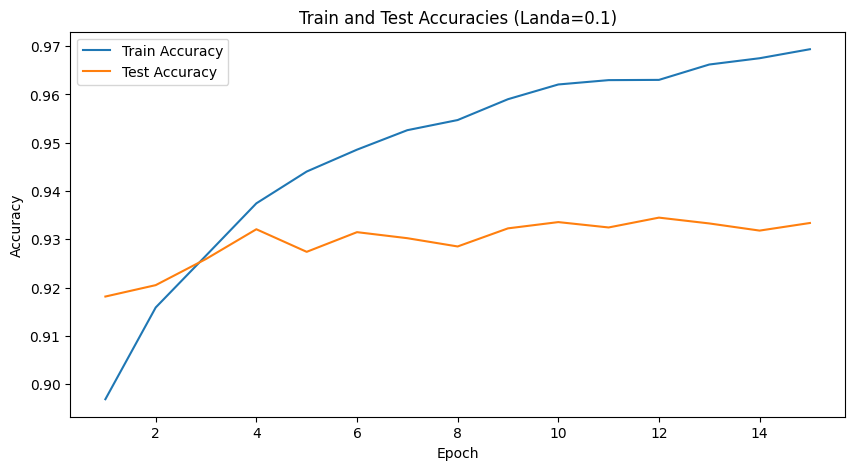

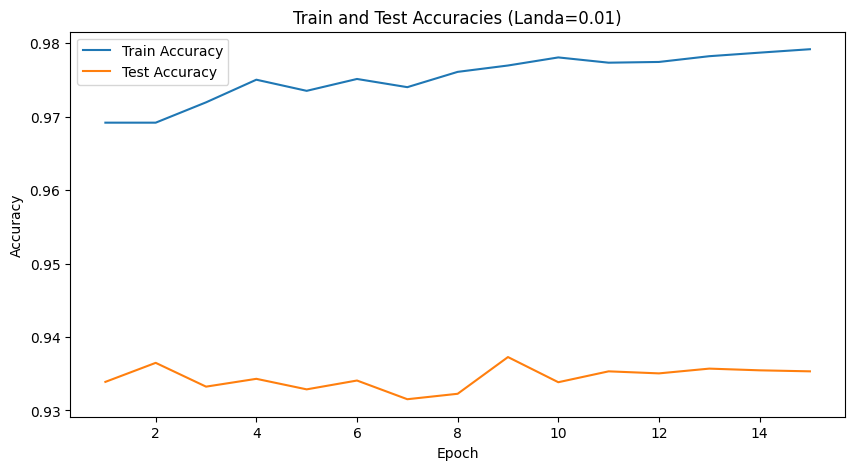

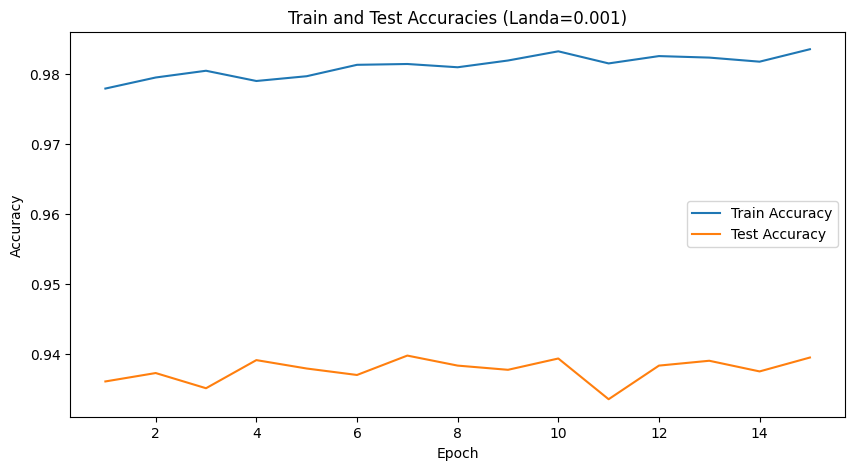

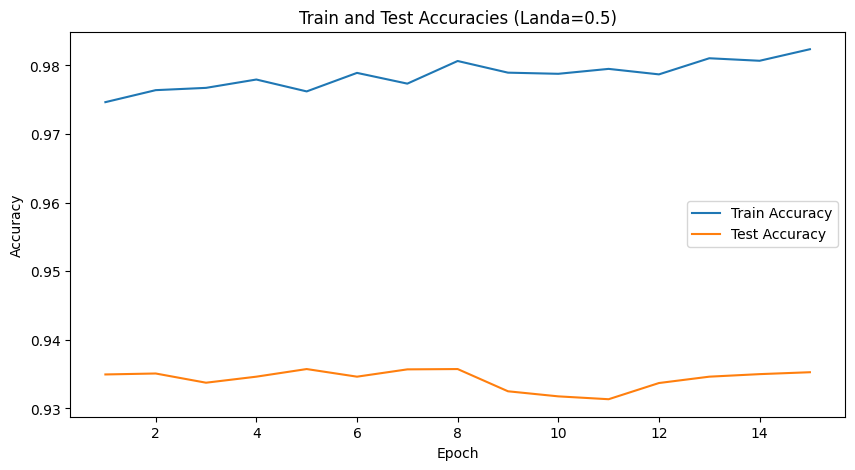

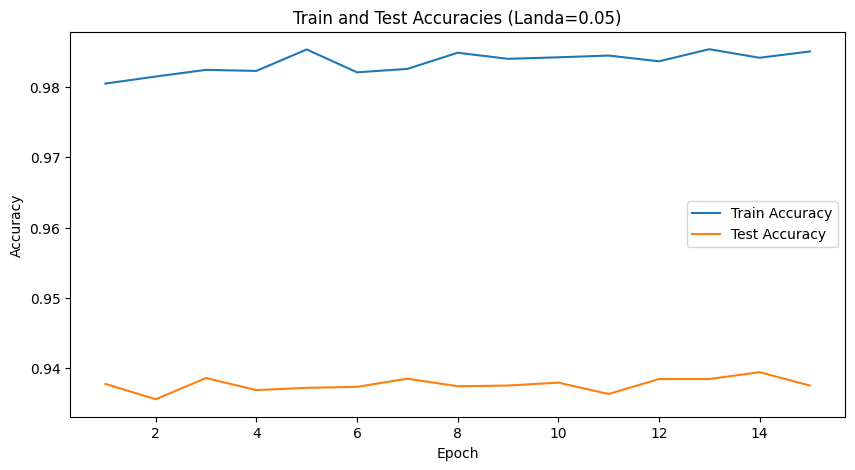

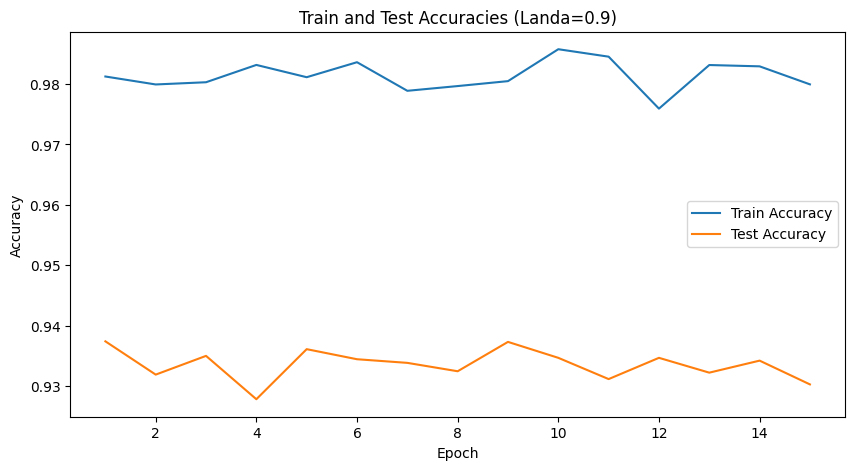

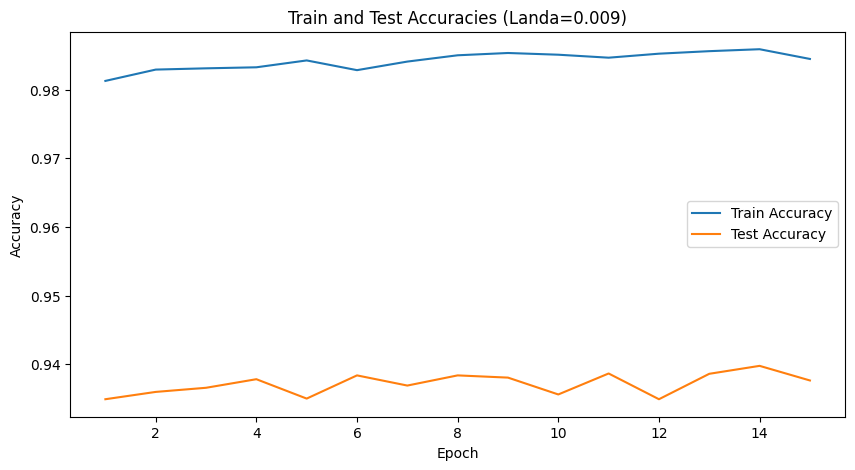

Best Landa: 0.001
Best Test Accuracy: 0.9394


In [53]:
# Plot train and test accuracies for each landa value
for i, result in enumerate(results):
    landa = result['landa']
    train_accuracy_values = result['train_accuracy']
    test_accuracy_values = result['test_accuracy']

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_accuracy_values, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), test_accuracy_values, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Train and Test Accuracies (Landa={landa})')
    plt.legend()
    plt.show()

# Find the best landa value based on max test accuracy
best_landa_index = max(range(len(results)), key=lambda i: results[i]['test_accuracy'][-1])
best_landa = landa_values[best_landa_index]
best_test_accuracy = results[best_landa_index]['test_accuracy'][-1]

print(f"Best Landa: {best_landa}")
print(f"Best Test Accuracy: {best_test_accuracy:.4f}")

Epoch 1/15
Train Accuracy: 0.9857 - Test Accuracy: 0.9373
Train Triplet Loss: 0.1824 - Test Triplet Loss: 2.4254
Train Cross Entropy Loss: 0.0476 - Test Cross Entropy Loss: 0.5494
Train Total Loss: 0.0658 - Test Total Loss: 2.9749

Epoch 2/15
Train Accuracy: 0.9878 - Test Accuracy: 0.9366
Train Triplet Loss: 0.1266 - Test Triplet Loss: 2.0520
Train Cross Entropy Loss: 0.0418 - Test Cross Entropy Loss: 0.5299
Train Total Loss: 0.0544 - Test Total Loss: 2.5819

Epoch 3/15
Train Accuracy: 0.9870 - Test Accuracy: 0.9364
Train Triplet Loss: 0.1305 - Test Triplet Loss: 2.4389
Train Cross Entropy Loss: 0.0439 - Test Cross Entropy Loss: 0.5311
Train Total Loss: 0.0570 - Test Total Loss: 2.9699

Epoch 4/15
Train Accuracy: 0.9862 - Test Accuracy: 0.9384
Train Triplet Loss: 0.1279 - Test Triplet Loss: 2.1021
Train Cross Entropy Loss: 0.0468 - Test Cross Entropy Loss: 0.5076
Train Total Loss: 0.0595 - Test Total Loss: 2.6097

Epoch 5/15
Train Accuracy: 0.9866 - Test Accuracy: 0.9331
Train Triplet 

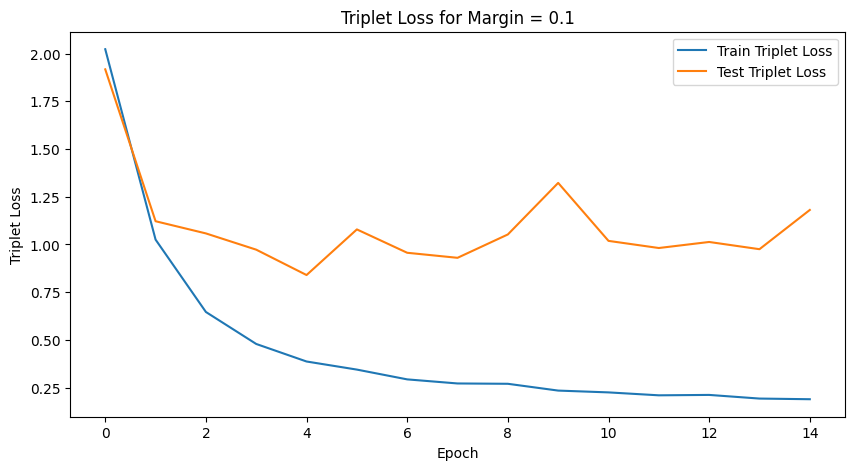

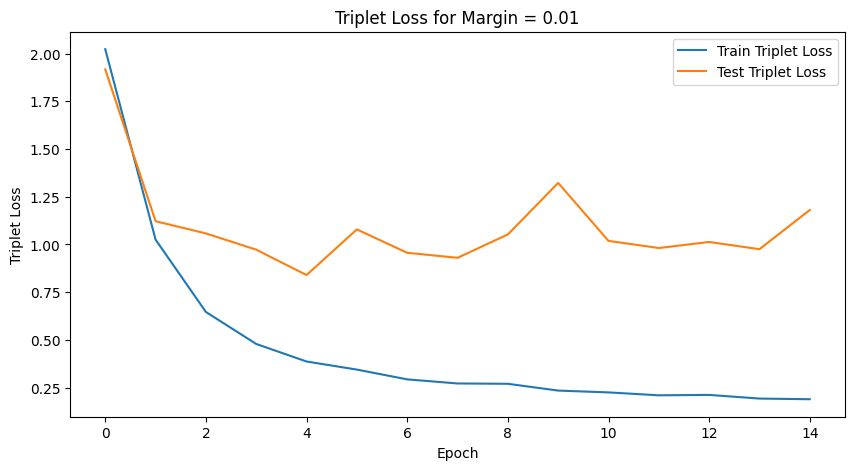

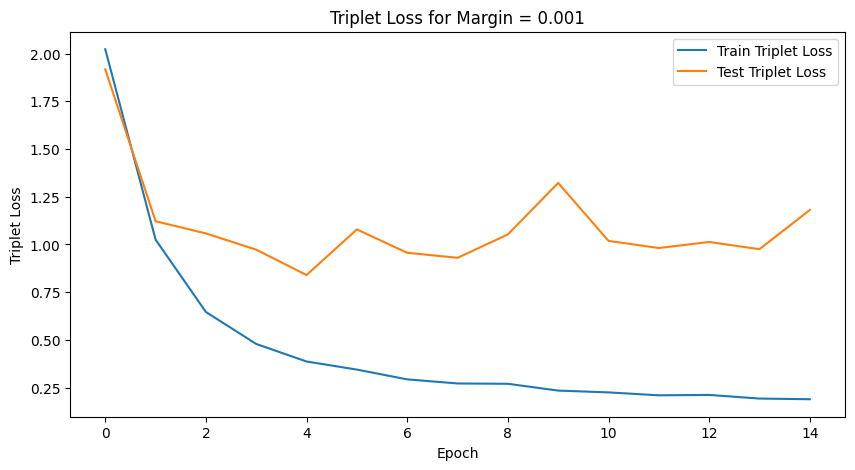

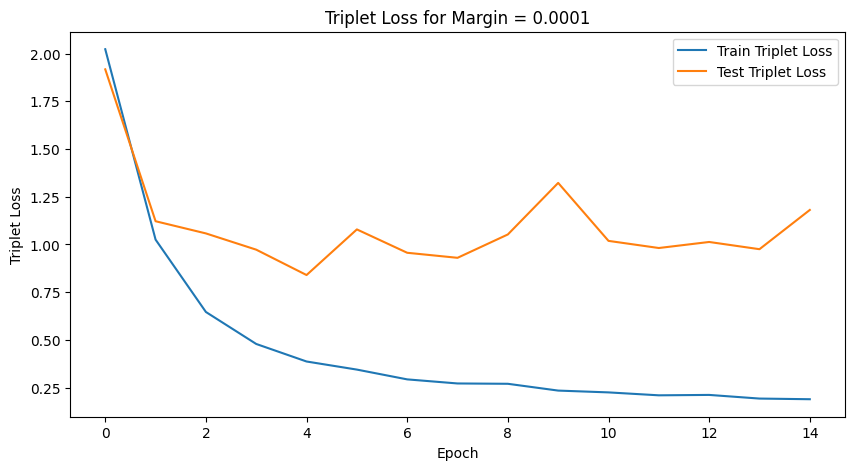

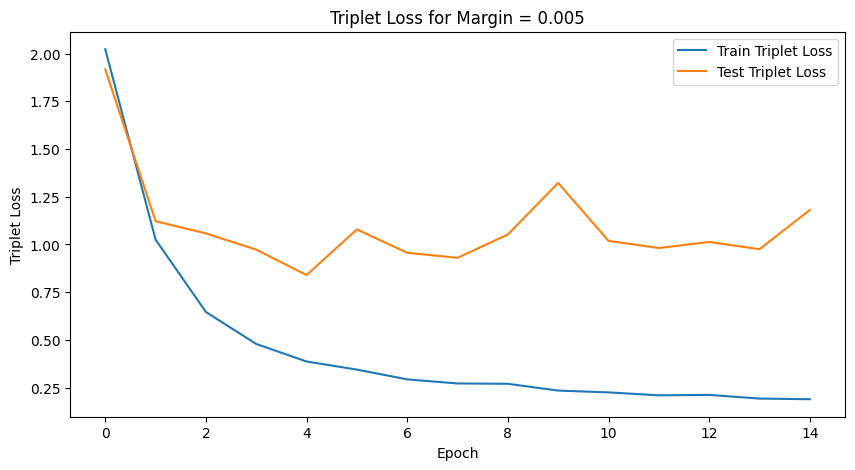

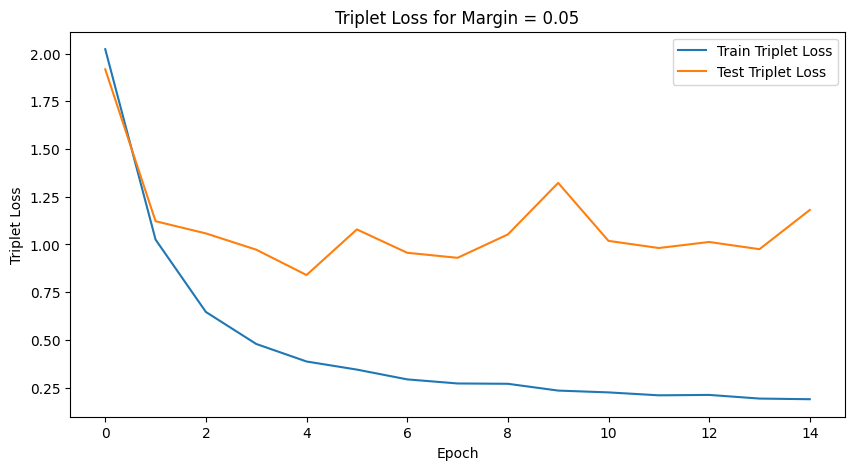

The best margin value is 0.1 with an average test triplet loss of 1.0944.


In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DigitCNNModel(nn.Module):
    def __init__(self, num_of_features, num_classes=10):
        super(DigitCNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Linear(64 * 4 * 4 + num_of_features, 256)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.output_layer = nn.Linear(256, num_classes)

    def forward(self, images, features):
        images = images.to(device)  # Move images to GPU
        images = images.to(self.conv_layers[0].weight.device)

        cnn_out = self.conv_layers(images)
        cnn_out = cnn_out.view(cnn_out.size(0), -1) # flatten
        representation_plus_features = torch.cat((cnn_out, features), dim=1)
        layer_before_output_layer_features = F.relu((self.fc(representation_plus_features)))
        dropout_output = self.dropout(layer_before_output_layer_features)
        output = self.output_layer(dropout_output)
        return layer_before_output_layer_features, output

# Define the training function
def train(model, train_loader, criterion, triplet_loss, optimizer, landa):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    for batch_idx, (images, features, domain_labels, digit_labels) in enumerate(train_loader):
        images = images.to(device)
        features = features.to(device)
        digit_labels = digit_labels.to(device)
        domain_labels = domain_labels.to(device)
        optimizer.zero_grad()
        f, output = model(images, features)
        loss_ce = criterion(output, digit_labels)
        loss_triplet = triplet_loss(f, domain_labels)
        loss = loss_ce + landa * loss_triplet
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

        triplet_loss_sum += loss_triplet.item()
        cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(train_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(train_loader)
    total_loss = running_loss / len(train_loader)
    return total_loss, accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss

# Define the evaluation function
def evaluate(model, test_loader, criterion, triplet_loss):
    model.eval()
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    with torch.no_grad():
        for images, features, domain_labels, digit_labels in test_loader:
            images = images.to(device)
            features = features.to(device)
            digit_labels = digit_labels.to(device)
            domain_labels = domain_labels.to(device)
            f, output = model(images, features)
            loss_ce = criterion(output, digit_labels)
            loss_triplet = triplet_loss(f, domain_labels)

            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

            triplet_loss_sum += loss_triplet.item()
            cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(test_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(test_loader)
    total_loss = (avg_triplet_loss + avg_cross_entropy_loss)
    return accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss, total_loss


# Access the train and test loaders using the keys 'train' and 'test'
train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']
# Training loop
num_epochs = 15
landa = 0.001
margin_values = [0.1, 0.01, 0.001, 0.0001, 0.005, 0.05]
results = []

train_accuracies = []
test_accuracies = []

for margin in margin_values:
    model = model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    triplet_loss = TripletLoss(margin=margin).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_accuracy_values = []
    test_accuracy_values = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy, train_triplet_loss, train_cross_entropy_loss = train(model, train_loader, criterion, triplet_loss, optimizer, landa)
        test_accuracy, test_triplet_loss, test_cross_entropy_loss, test_total_loss = evaluate(model, test_loader, criterion, triplet_loss)

        train_accuracy_values.append(train_accuracy)
        test_accuracy_values.append(test_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Accuracy: {train_accuracy:.4f} - Test Accuracy: {test_accuracy:.4f}")
        print(f"Train Triplet Loss: {train_triplet_loss:.4f} - Test Triplet Loss: {test_triplet_loss:.4f}")
        print(f"Train Cross Entropy Loss: {train_cross_entropy_loss:.4f} - Test Cross Entropy Loss: {test_cross_entropy_loss:.4f}")
        print(f"Train Total Loss: {train_loss:.4f} - Test Total Loss: {test_total_loss:.4f}")
        print()

    train_accuracies.append(train_accuracy_values)
    test_accuracies.append(test_accuracy_values)

    results.append({
      'margin': margin,
      'train_losses': train_losses,
      'test_losses': test_losses,
      'train_triplet_losses': train_triplet_losses,
      'test_triplet_losses': test_triplet_losses,
      'train_cross_entropy_losses': train_cross_entropy_losses,
      'test_cross_entropy_losses': test_cross_entropy_losses,
      'train_accuracies': train_accuracies,
      'test_accuracies': test_accuracies
  })

# Plot the triplet losses for each margin value
for result in results:
    margin = result['margin']
    train_triplet_losses = result['train_triplet_losses']
    test_triplet_losses = result['test_triplet_losses']

    plt.figure(figsize=(10, 5))
    plt.plot(train_triplet_losses, label='Train Triplet Loss')
    plt.plot(test_triplet_losses, label='Test Triplet Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Triplet Loss')
    plt.legend()
    plt.title(f'Triplet Loss for Margin = {margin}')
    plt.show()

# Analyze the results
best_margin = None
best_avg_triplet_loss = float('inf')

for result in results:
    margin = result['margin']
    test_triplet_losses = result['test_triplet_losses']
    avg_triplet_loss = sum(test_triplet_losses) / len(test_triplet_losses)

    if avg_triplet_loss < best_avg_triplet_loss:
        best_margin = margin
        best_avg_triplet_loss = avg_triplet_loss

print(f"The best margin value is {best_margin} with an average test triplet loss of {best_avg_triplet_loss:.4f}.")





Epoch 1/15
Train Loss: 0.9925 - Missing-Test Loss: 2.6066
Train Accuracy: 0.7621 - Missing-Test Accuracy: 0.8808
Train Triplet Loss: 2.1284 - Missing-Test Triplet Loss: 2.1419
Train Cross Entropy Loss: 0.7797 - Missing-Test Cross Entropy Loss: 0.4647
Train Total Loss: 0.9925 - Missing-Test Total Loss: 2.6066

Epoch 2/15
Train Loss: 0.4781 - Missing-Test Loss: 2.2197
Train Accuracy: 0.8906 - Missing-Test Accuracy: 0.8986
Train Triplet Loss: 1.2001 - Missing-Test Triplet Loss: 1.8667
Train Cross Entropy Loss: 0.3581 - Missing-Test Cross Entropy Loss: 0.3530
Train Total Loss: 0.4781 - Missing-Test Total Loss: 2.2197

Epoch 3/15
Train Loss: 0.3555 - Missing-Test Loss: 2.2899
Train Accuracy: 0.9127 - Missing-Test Accuracy: 0.9121
Train Triplet Loss: 0.7479 - Missing-Test Triplet Loss: 1.9553
Train Cross Entropy Loss: 0.2808 - Missing-Test Cross Entropy Loss: 0.3346
Train Total Loss: 0.3555 - Missing-Test Total Loss: 2.2899

Epoch 4/15
Train Loss: 0.2874 - Missing-Test Loss: 2.7543
Train Acc

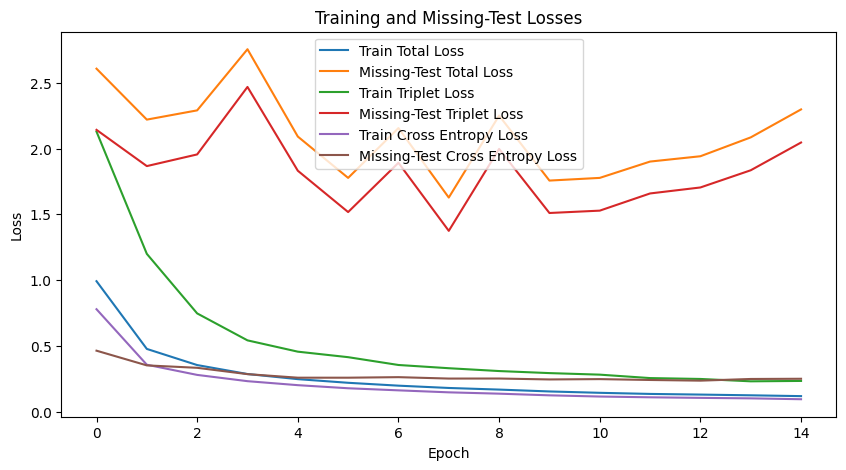

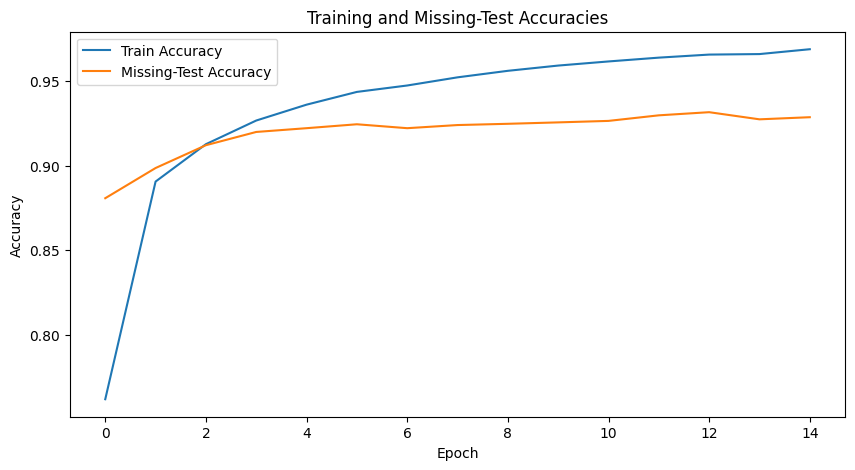

In [16]:
class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 4 * 4 + num_features, 256)
        self.dropout = nn.Dropout(0.5)
        self.output_layer = nn.Linear(256, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)  # Flatten the CNN output
        combined = torch.cat((cnn_output, features), dim=1)
        layer_before_output_layer_features = F.relu(self.fc(combined))
        dropout_output = self.dropout(layer_before_output_layer_features)
        output = self.output_layer(dropout_output)
        return layer_before_output_layer_features, output

# Define the training function
def train(model, train_loader, criterion, triplet_loss, optimizer, landa):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    for batch_idx, (images, features, domain_labels, digit_labels) in enumerate(train_loader):
        optimizer.zero_grad()
        f, output = model(images, features)
        loss_ce = criterion(output, digit_labels)
        loss_triplet = triplet_loss(f, domain_labels)
        loss = loss_ce + landa * loss_triplet
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

        triplet_loss_sum += loss_triplet.item()
        cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(train_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(train_loader)
    total_loss = running_loss / len(train_loader)
    return total_loss, accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss


# Define the evaluation function
def evaluate(model, test_loader, criterion, triplet_loss):
    model.eval()
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    with torch.no_grad():
        for images, features, domain_labels, digit_labels in test_loader:
            f, output = model(images, features)
            loss_ce = criterion(output, digit_labels)
            loss_triplet = triplet_loss(f, domain_labels)

            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

            triplet_loss_sum += loss_triplet.item()
            cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(test_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(test_loader)
    total_loss = (avg_triplet_loss + avg_cross_entropy_loss)
    return accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss, total_loss


# Example usage
model = DigitModel(num_features=256)
criterion = nn.CrossEntropyLoss()
triplet_loss = TripletLoss(margin=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = full_dataloaders['train']
missing_test_loader = full_dataloaders['test_missing']

import matplotlib.pyplot as plt

# Training loop
num_epochs = 15
landa = 0.1

train_losses = []
missing_test_losses = []
train_triplet_losses = []
missing_test_triplet_losses = []
train_cross_entropy_losses = []
missing_test_cross_entropy_losses = []
train_accuracies = []
missing_test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy, train_triplet_loss, train_cross_entropy_loss = train(model, train_loader, criterion, triplet_loss, optimizer, landa)
    missing_test_accuracy, missing_test_triplet_loss, missing_test_cross_entropy_loss, missing_test_total_loss = evaluate(model, missing_test_loader, criterion, triplet_loss)

    train_losses.append(train_loss)
    missing_test_losses.append(missing_test_total_loss)
    train_triplet_losses.append(train_triplet_loss)
    missing_test_triplet_losses.append(missing_test_triplet_loss)
    train_cross_entropy_losses.append(train_cross_entropy_loss)
    missing_test_cross_entropy_losses.append(missing_test_cross_entropy_loss)
    train_accuracies.append(train_accuracy)
    missing_test_accuracies.append(missing_test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} - Missing-Test Loss: {missing_test_total_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f} - Missing-Test Accuracy: {missing_test_accuracy:.4f}")
    print(f"Train Triplet Loss: {train_triplet_loss:.4f} - Missing-Test Triplet Loss: {missing_test_triplet_loss:.4f}")
    print(f"Train Cross Entropy Loss: {train_cross_entropy_loss:.4f} - Missing-Test Cross Entropy Loss: {missing_test_cross_entropy_loss:.4f}")
    print(f"Train Total Loss: {train_loss:.4f} - Missing-Test Total Loss: {missing_test_total_loss:.4f}")
    print()

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Total Loss')
plt.plot(missing_test_losses, label='Missing-Test Total Loss')
plt.plot(train_triplet_losses, label='Train Triplet Loss')
plt.plot(missing_test_triplet_losses, label='Missing-Test Triplet Loss')
plt.plot(train_cross_entropy_losses, label='Train Cross Entropy Loss')
plt.plot(missing_test_cross_entropy_losses, label='Missing-Test Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Missing-Test Losses')
plt.show()

# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(missing_test_accuracies, label='Missing-Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Missing-Test Accuracies')
plt.show()


Epoch 1/15
Train Loss: 0.9514 - Missing-Test Loss: 3.6390
Train Accuracy: 0.7746 - Missing-Test Accuracy: 0.8926
Train Triplet Loss: 2.0698 - Missing-Test Triplet Loss: 3.2653
Train Cross Entropy Loss: 0.7444 - Missing-Test Cross Entropy Loss: 0.3737
Train Total Loss: 0.9514 - Missing-Test Total Loss: 3.6390

Epoch 2/15
Train Loss: 0.4513 - Missing-Test Loss: 2.0988
Train Accuracy: 0.8944 - Missing-Test Accuracy: 0.9001
Train Triplet Loss: 1.0445 - Missing-Test Triplet Loss: 1.7607
Train Cross Entropy Loss: 0.3469 - Missing-Test Cross Entropy Loss: 0.3382
Train Total Loss: 0.4513 - Missing-Test Total Loss: 2.0988

Epoch 3/15
Train Loss: 0.3375 - Missing-Test Loss: 2.6506
Train Accuracy: 0.9173 - Missing-Test Accuracy: 0.9179
Train Triplet Loss: 0.6871 - Missing-Test Triplet Loss: 2.3677
Train Cross Entropy Loss: 0.2688 - Missing-Test Cross Entropy Loss: 0.2829
Train Total Loss: 0.3375 - Missing-Test Total Loss: 2.6506

Epoch 4/15
Train Loss: 0.2800 - Missing-Test Loss: 3.1604
Train Acc

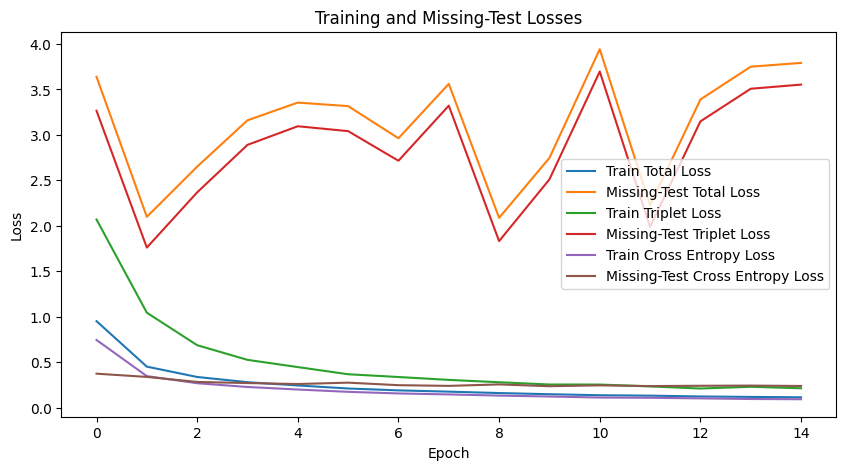

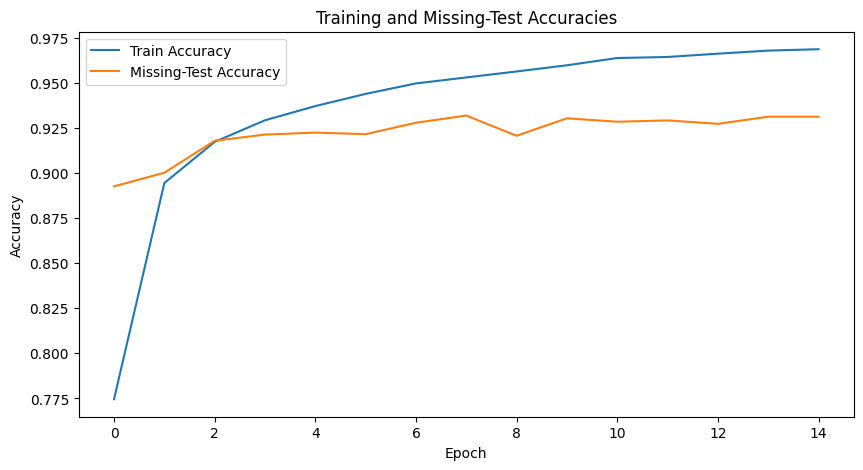

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torchvision.transforms as transforms

# Data augmentation transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomRotation(10, fill=(0, 0, 0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

def get_data_loaders(file_paths, batch_size):
    train_dataset = DigitDataset(file_paths['train'], transform=transform)
    test_dataset = DigitDataset(file_paths['test'])
    missing_test_dataset = DigitDataset(file_paths['missing_test'])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    missing_test_loader = DataLoader(missing_test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, missing_test_loader



class DigitDataset(Dataset):
    def __init__(self, file_path, transform=None):
        data = np.load(file_path)
        self.images = data['images']
        self.features = data['features']
        self.domain_labels = data['domain_labels']
        self.digit_labels = data['digit_labels']
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]
        feature = self.features[index]
        domain_label = self.domain_labels[index]
        digit_label = self.digit_labels[index]

        if self.transform:
            image = self.transform(image)

        return image, feature, domain_label, digit_label

    def __len__(self):
        return len(self.images)


class DigitModel(nn.Module):
    def __init__(self, num_features):
        super(DigitModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(64 * 4 * 4 + num_features, 256)
        self.dropout = nn.Dropout(0.5)
        self.output_layer = nn.Linear(256, 10)

    def forward(self, images, features):
        cnn_output = self.cnn(images)
        cnn_output = cnn_output.view(cnn_output.size(0), -1)  # Flatten the CNN output
        combined = torch.cat((cnn_output, features), dim=1)
        layer_before_output_layer_features = F.relu(self.fc(combined))
        dropout_output = self.dropout(layer_before_output_layer_features)
        output = self.output_layer(dropout_output)
        return layer_before_output_layer_features, output



# Define the training function
def train(model, train_loader, criterion, triplet_loss, optimizer, landa):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    for batch_idx, (images, features, domain_labels, digit_labels) in enumerate(train_loader):
        optimizer.zero_grad()
        f, output = model(images, features)
        loss_ce = criterion(output, digit_labels)
        loss_triplet = triplet_loss(f, domain_labels)
        loss = loss_ce + landa * loss_triplet
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

        triplet_loss_sum += loss_triplet.item()
        cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(train_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(train_loader)
    total_loss = running_loss / len(train_loader)
    return total_loss, accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss


# Define the evaluation function
def evaluate(model, test_loader, criterion, triplet_loss):
    model.eval()
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    with torch.no_grad():
        for images, features, domain_labels, digit_labels in test_loader:
            f, output = model(images, features)
            loss_ce = criterion(output, digit_labels)
            loss_triplet = triplet_loss(f, domain_labels)

            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

            triplet_loss_sum += loss_triplet.item()
            cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(test_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(test_loader)
    total_loss = (avg_triplet_loss + avg_cross_entropy_loss)
    return accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss, total_loss


# Example usage
model = DigitModel(num_features=256)
criterion = nn.CrossEntropyLoss()
triplet_loss = TripletLoss(margin=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Access the train and missing_test loaders using the keys 'train' and 'missing_test'
train_loader = full_dataloaders['train']
missing_test_loader = full_dataloaders['test_missing']


# Training loop
num_epochs = 15
landa = 0.1  # Hyperparameter to control the impact of the Triplet Loss

train_losses = []
missing_test_losses = []
train_triplet_losses = []
missing_test_triplet_losses = []
train_cross_entropy_losses = []
missing_test_cross_entropy_losses = []
train_accuracies = []
missing_test_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy, train_triplet_loss, train_cross_entropy_loss = train(model, train_loader, criterion, triplet_loss, optimizer, landa)
    missing_test_accuracy, missing_test_triplet_loss, missing_test_cross_entropy_loss, missing_test_total_loss = evaluate(model, missing_test_loader, criterion, triplet_loss)

    train_losses.append(train_loss)
    missing_test_losses.append(missing_test_total_loss)
    train_triplet_losses.append(train_triplet_loss)
    missing_test_triplet_losses.append(missing_test_triplet_loss)
    train_cross_entropy_losses.append(train_cross_entropy_loss)
    missing_test_cross_entropy_losses.append(missing_test_cross_entropy_loss)
    train_accuracies.append(train_accuracy)
    missing_test_accuracies.append(missing_test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} - Missing-Test Loss: {missing_test_total_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f} - Missing-Test Accuracy: {missing_test_accuracy:.4f}")
    print(f"Train Triplet Loss: {train_triplet_loss:.4f} - Missing-Test Triplet Loss: {missing_test_triplet_loss:.4f}")
    print(f"Train Cross Entropy Loss: {train_cross_entropy_loss:.4f} - Missing-Test Cross Entropy Loss: {missing_test_cross_entropy_loss:.4f}")
    print(f"Train Total Loss: {train_loss:.4f} - Missing-Test Total Loss: {missing_test_total_loss:.4f}")
    print()

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Total Loss')
plt.plot(missing_test_losses, label='Missing-Test Total Loss')
plt.plot(train_triplet_losses, label='Train Triplet Loss')
plt.plot(missing_test_triplet_losses, label='Missing-Test Triplet Loss')
plt.plot(train_cross_entropy_losses, label='Train Cross Entropy Loss')
plt.plot(missing_test_cross_entropy_losses, label='Missing-Test Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Missing-Test Losses')
plt.show()

# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(missing_test_accuracies, label='Missing-Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Missing-Test Accuracies')
plt.show()


Epoch: 1/15
Train Loss: 0.955359 | Train Accuracy: 0.7622
Train Triplet Loss: 2.001714 | Train Cross-Entropy Loss: 0.755188
Test Accuracy: 0.8864
Test Triplet Loss: 1.521600 | Test Cross-Entropy Loss: 0.390503
Test Total Loss: 1.912102
Missing Test Accuracy: 0.8864
Missing Test Triplet Loss: 1.518163 | Missing Test Cross-Entropy Loss: 0.390413
Missing Test Total Loss: 1.908575
--------------------------------------------------------------
Epoch: 2/15
Train Loss: 0.389186 | Train Accuracy: 0.9071
Train Triplet Loss: 0.795132 | Train Cross-Entropy Loss: 0.309673
Test Accuracy: 0.9173
Test Triplet Loss: 0.866020 | Test Cross-Entropy Loss: 0.292324
Test Total Loss: 1.158345
Missing Test Accuracy: 0.9173
Missing Test Triplet Loss: 0.867896 | Missing Test Cross-Entropy Loss: 0.291932
Missing Test Total Loss: 1.159828
--------------------------------------------------------------
Epoch: 3/15
Train Loss: 0.291591 | Train Accuracy: 0.9273
Train Triplet Loss: 0.502463 | Train Cross-Entropy Loss:

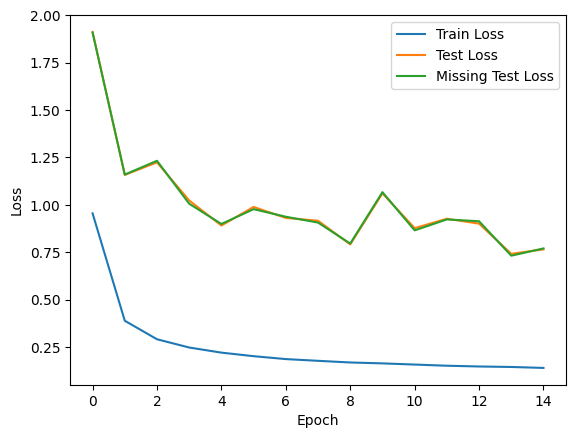

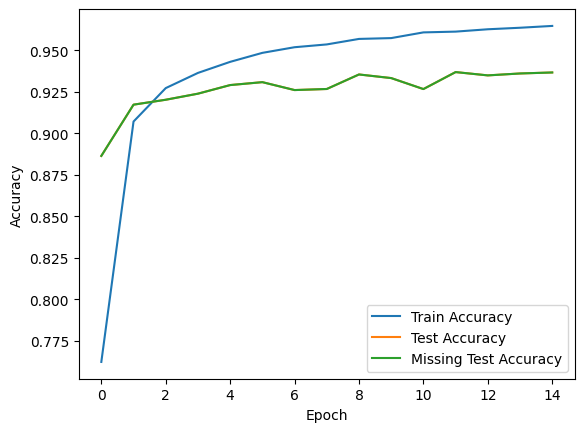

In [22]:
# changing network architecture

class DigitCNNModel(nn.Module):
    def __init__(self, num_of_features, num_classes=10):
        super(DigitCNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
                    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=2, stride=2)
                )

        self.fc = nn.Linear(128 * 4 * 4, 256)
        self.dropout = nn.Dropout(0.5)
        self.output_layer = nn.Linear(256, num_classes)

    def forward(self, images, features):
        cnn_out = self.conv_layers(images)
        cnn_out = cnn_out.view(cnn_out.size(0), -1) # flatten
        layer_before_output_layer_features = F.relu(self.fc(cnn_out))
        output = self.output_layer(layer_before_output_layer_features)
        return layer_before_output_layer_features, output

def train(model, train_loader, criterion, triplet_loss, optimizer, landa):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    for batch_idx, (images, features, domain_labels, digit_labels) in enumerate(train_loader):
        optimizer.zero_grad()
        input_to_last_layer, output = model(images, features)
        loss_ce = criterion(output, digit_labels)
        loss_triplet = triplet_loss(input_to_last_layer, domain_labels)
        loss = loss_ce + landa * loss_triplet
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += digit_labels.size(0)
        correct += (predicted == digit_labels).sum().item()

        triplet_loss_sum += loss_triplet.item()
        cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(train_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(train_loader)
    total_loss = running_loss / len(train_loader)
    return total_loss, accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss


# Define the evaluation function
def evaluate(model, test_loader, criterion, triplet_loss):
    model.eval()
    correct = 0
    total = 0
    triplet_loss_sum = 0.0
    cross_entropy_loss_sum = 0.0
    with torch.no_grad():
        for images, features, domain_labels, digit_labels in test_loader:
            f, output = model(images, features)
            loss_ce = criterion(output, digit_labels)
            loss_triplet = triplet_loss(f, domain_labels)

            _, predicted = torch.max(output.data, 1)
            total += digit_labels.size(0)
            correct += (predicted == digit_labels).sum().item()

            triplet_loss_sum += loss_triplet.item()
            cross_entropy_loss_sum += loss_ce.item()

    accuracy_ce = correct / total
    avg_triplet_loss = triplet_loss_sum / len(test_loader)
    avg_cross_entropy_loss = cross_entropy_loss_sum / len(test_loader)
    total_loss = (avg_triplet_loss + avg_cross_entropy_loss)
    return accuracy_ce, avg_triplet_loss, avg_cross_entropy_loss, total_loss


# Set random seeds for reproducibility
torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() and use_gpu else "cpu")

# Define hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 10
margin = 0.1
landa = 0.1


train_loader = full_dataloaders['train']
test_loader = full_dataloaders['test']
missing_test_loader = full_dataloaders['test_missing']


# Initialize the model
num_features = 256  # Change this according to your feature size
model = DigitCNNModel(num_features).to(device)

# Define the criterion, optimizer, and triplet loss
criterion = nn.CrossEntropyLoss()
triplet_loss = TripletLoss(margin)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

# Training loop
train_losses = []
test_losses = []
missing_test_losses = []
train_accuracies = []
test_accuracies = []
missing_test_accuracies = []
num_epochs = 15
for epoch in range(num_epochs):
    # Train the model
    train_loss, train_accuracy, avg_triplet_loss, avg_cross_entropy_loss = train(model, train_loader, criterion, triplet_loss, optimizer, landa)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate the model
    test_accuracy, test_triplet_loss, test_cross_entropy_loss, test_total_loss = evaluate(model, test_loader, criterion, triplet_loss)
    test_losses.append(test_total_loss)
    test_accuracies.append(test_accuracy)

    # Test the model on the missing test dataset
    missing_test_accuracy, missing_test_triplet_loss, missing_test_cross_entropy_loss, missing_test_total_loss = evaluate(model, missing_test_loader, criterion, triplet_loss)
    missing_test_losses.append(missing_test_total_loss)
    missing_test_accuracies.append(missing_test_accuracy)

    # Print the progress
    print(f"Epoch: {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.6f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Train Triplet Loss: {avg_triplet_loss:.6f} | Train Cross-Entropy Loss: {avg_cross_entropy_loss:.6f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Triplet Loss: {test_triplet_loss:.6f} | Test Cross-Entropy Loss: {test_cross_entropy_loss:.6f}")
    print(f"Test Total Loss: {test_total_loss:.6f}")
    print(f"Missing Test Accuracy: {missing_test_accuracy:.4f}")
    print(f"Missing Test Triplet Loss: {missing_test_triplet_loss:.6f} | Missing Test Cross-Entropy Loss: {missing_test_cross_entropy_loss:.6f}")
    print(f"Missing Test Total Loss: {missing_test_total_loss:.6f}")
    print("--------------------------------------------------------------")

# Plot the train and test losses
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.plot(missing_test_losses, label="Missing Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the train and test accuracies
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.plot(missing_test_accuracies, label="Missing Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



Authors: Pouria Nazemi - Tahoora Saeedi